In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path as pt
from scipy.optimize import curve_fit
from scipy.constants import Boltzmann, Planck, speed_of_light
from functools import reduce
from scipy.integrate import solve_ivp

In [2]:
location = pt(r"D:\SurfDrive\THz_Measurements\Simulations")
saveLocation = location/"OUT"
files = [*location.glob("*.txt")]
_file = location/"CH+He_collisionalRateConstant.txt"
_file.exists()

True

In [3]:
k_boltzmann_wavenumber = Boltzmann/1.98630e-23
def distribution(j0, j1, temp, q=None):
    KT = k_boltzmann_wavenumber*temp
    N0 = 2*j0+1
    N1 = 2*j1+1

    Gj = N1/N0
    delE = abs(Energy[j0]-Energy[j1])
    if q: return q*Gj*np.exp(-delE/KT)
    return Gj*np.exp(-delE/KT)

def boltzman_distribution(energyLevels, temp=5):
    KT = k_boltzmann_wavenumber*temp
    Nj = [(2*i+1)*np.exp(-energy/KT) for i, energy in enumerate(energyLevels)]
    Nj = np.array(Nj, dtype=np.float)
    Nj = Nj/Nj.sum()
    
    return Nj

In [4]:
def getNjFromFile(totallevel=6, samelevelExist=True):
    rate_constants_fullContents = {}
    counter = 0
    for n in range(1, totallevel):
        for _temp in range(n+1):
            if _temp != n: 
                rate_constants_fullContents[f"{n}{_temp}"] = fileContents[counter]
                if not samelevelExist: counter += 1
            if samelevelExist: counter += 1
    
    return rate_constants_fullContents

In [5]:
def fitfunc(x, m, c): return m * x + c
def getRateConstantFromFit(temp, rate_constants_fullContents):
    rate_constants = {}
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    color = 0
    for key, value in rate_constants_fullContents.items():
        tempRange = np.array([0.1, 1, 10, 30])
        rateRange = value[2:len(tempRange)+2]

        pop, popc = curve_fit(fitfunc, tempRange, rateRange)
        Kjj = fitfunc(temp, *pop)
        distribution_j_list = [int(key[1]), int(key[0])]

        rate_constants[f"{key}"] = Kjj

        rate_constants[f"{key[1]}{key[0]}"] = distribution(*distribution_j_list, temp, Kjj)

        ax.plot(tempRange, rateRange, f"C{color}.")
        ax.plot(tempRange, fitfunc(tempRange, *pop), f"C{color}-", label=f"{key}")
        ax.set(xlabel="Temp (K)", \
                ylabel="k$_{jj'}$ (cm$^3$ molecule$^{-1}$ s$^{-1}$)", \
                title="Collisional rate constants", \
                yscale="log")
        color += 1
        if color > 9: color = 0
            
    return rate_constants, fig, ax

In [6]:
def collisionalRateDistribution(t, N):
    _N = [f"N{i}" for i in range(len(N))]
    _rateCollection = []
    rateCollection = []
    
    for i in range(totallevel):
        _collisional = []
        collisional = []

        for j in range(totallevel):
            if i!= j: 
                key = f"{j}{i}"
                keyInverse = f"{i}{j}"
                _k = f" + q_{key}*{_N[j]} - q_{keyInverse}*{_N[i]}"
                _collisional.append(_k)
                
                k = rate_constants[key]*nHe*N[j] - rate_constants[keyInverse]*nHe*N[i]
                collisional.append(k)

                
        _rateCollection.append(_collisional)
        rateCollection.append(collisional)
    
    dR_dt = []

    for _ in rateCollection:
        _temp = reduce(lambda a, b: a+b, _)
        dR_dt.append(_temp)
    
    return dR_dt

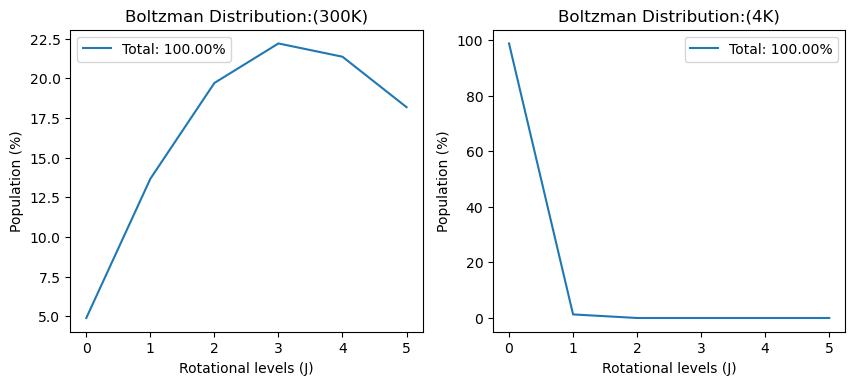

In [7]:
fileContents = np.genfromtxt(_file)
Energy = np.array([0, 15.127861, 45.373851, 90.718526, 151.132755, 226.577764])

sourceTemp = 300
boltzman_distribution_source = boltzman_distribution(Energy, sourceTemp)*100

trapTemp = 4

boltzman_distribution_trap = boltzman_distribution(Energy, trapTemp)*100

totallevel = 6
fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)

ax0.plot(np.arange(totallevel), boltzman_distribution_source)
ax1.plot(np.arange(totallevel), boltzman_distribution_trap)
ax0.set(xlabel="Rotational levels (J)", ylabel="Population (%)", title=f"Boltzman Distribution:({sourceTemp}K)")

ax1.set(xlabel="Rotational levels (J)", ylabel="Population (%)", title=f"Boltzman Distribution:({trapTemp}K)")

ax0.legend([f"Total: {boltzman_distribution_source.sum():.2f}%"])
ax1.legend([f"Total: {boltzman_distribution_trap.sum():.2f}%"])

#fig1.savefig(f"{saveLocation/'boltzmanDistribution'}.png")

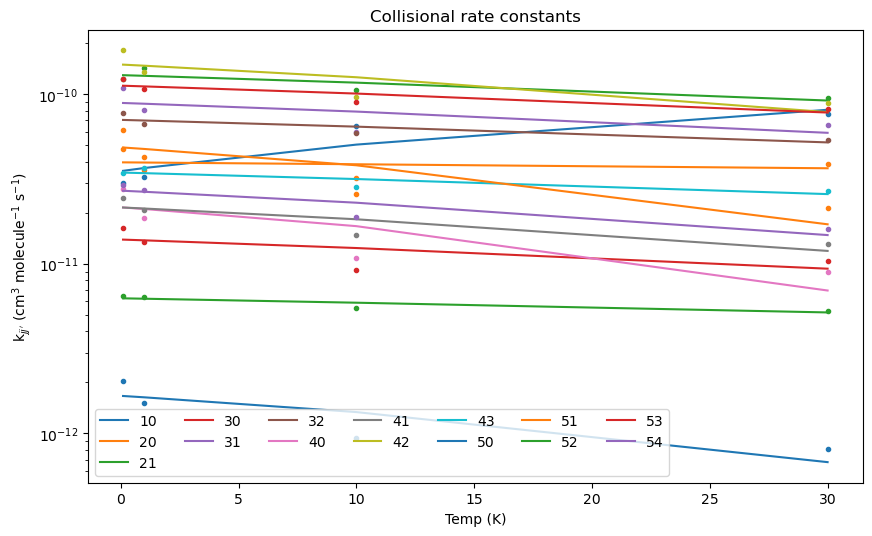

In [8]:
rate_constants_fullContents= getNjFromFile(totallevel)
rate_constants, fig2, ax2 = getRateConstantFromFit(trapTemp, rate_constants_fullContents)
ax2.legend(ncol=7)
fig2.savefig(f"{saveLocation/'collisionalRateConstants'}.png")

Wall time: 153 ms


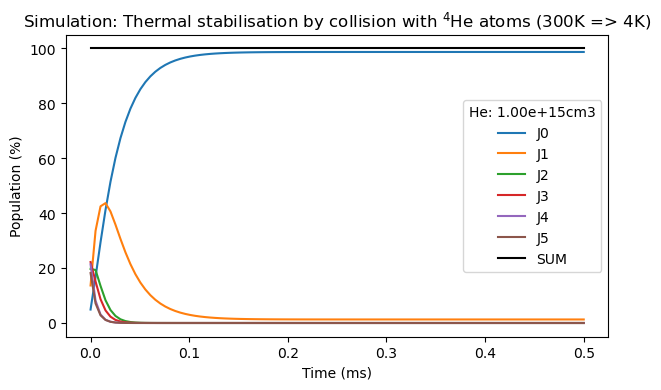

In [9]:
%%time
nHe = 1e15
t = 5e-4
tspan = [0, t] # 0 - 2 ms
N_collisional = solve_ivp(collisionalRateDistribution, tspan, boltzman_distribution_source, dense_output=True)

simulateTime = np.linspace(0, t, 100)
simulateCounts = N_collisional.sol(simulateTime)
fig3, ax3 = plt.subplots(figsize=(7, 4), dpi=100)

ax3.plot(simulateTime.T*1e3, simulateCounts.T)

ax3.plot(simulateTime*1e3, simulateCounts.sum(axis=0), "k")


ax3.legend([*[f"J{i}" for i in range(totallevel)], "SUM"], title=f"He: {nHe:.2e}cm3")

ax3.set(xlabel="Time (ms)", ylabel="Population (%)",\
       title="Simulation: Thermal stabilisation by collision with $^4$He atoms "+f"({sourceTemp}K => {trapTemp}K)")

fig3.savefig(f"{saveLocation/'thermalStabilisation'}_{nHe:.2e}.png")

In [10]:
def steadyStateTime(nHe_range, t=1e-3):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
    for nHe in nHe_range:
        nHe = 5e14
        rate_constants, *_ = getRateConstantFromFit(trapTemp, nHe, rate_constants_fullContents)

        tspan = [0, t] # 0 - 2 ms
        N_collisional = solve_ivp(collisionalRateDistribution, tspan, boltzman_distribution_source, dense_output=True)

        simulateTime = np.linspace(0, t, 100)
        simulateCounts = N_collisional.sol(simulateTime)
        
        ax.plot(simulateTime.T*1e3, simulateCounts.T)
        ax.plot(simulateTime*1e3, simulateCounts.sum(axis=0), "k")

nHe_range = np.linspace(1e12, 1e16, 10)
#steadyStateTime(nHe_range)

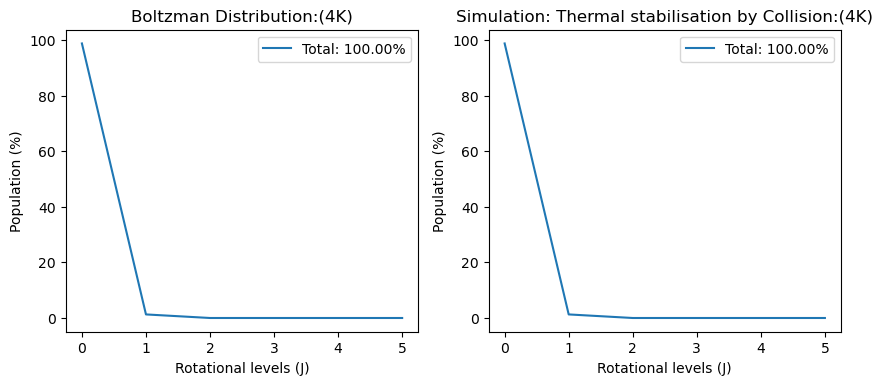

In [11]:
fig4, (ax4, ax5) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)

ax4.plot(np.arange(totallevel), boltzman_distribution_trap)
ax5.plot(np.arange(totallevel), simulateCounts.T[-1])

ax4.set(xlabel="Rotational levels (J)", ylabel="Population (%)", title=f"Boltzman Distribution:({trapTemp}K)")
ax5.set(xlabel="Rotational levels (J)", ylabel="Population (%)", title=f"Simulation: Thermal stabilisation by Collision:({trapTemp}K)")

ax4.legend([f"Total: {boltzman_distribution_trap.sum():.2f}%"])

ax5.legend([f"Total: {simulateCounts.T[-1].sum():.2f}%"])
fig4.savefig(f"{saveLocation/'thermalStabilisationDistribution'}_{nHe:.2e}.png")

In [20]:
simulateCounts.T[-1]

array([ 9.87161191e+01,  1.28384081e+00,  4.00265494e-05, -1.25230348e-07,
        1.76427065e-07,  1.16824562e-13])

In [21]:
rate_constants

{'10': 4.129378677912417e-11,
 '01': 5.370413016964461e-13,
 '20': 3.9250811501906335e-11,
 '02': 1.604515671564093e-17,
 '21': 1.2457658629399757e-10,
 '12': 3.915694249155681e-15,
 '30': 1.3300641305139243e-11,
 '03': 6.288956651279833e-25,
 '31': 8.492073041429557e-11,
 '13': 3.087427476429531e-22,
 '32': 6.81110895320521e-11,
 '23': 7.878227614019649e-18,
 '40': 1.9592328097461816e-11,
 '04': 4.3564082451697345e-34,
 '41': 2.0228703502551757e-11,
 '14': 3.4584985614919885e-32,
 '42': 1.4015052278175817e-10,
 '24': 7.623280943803213e-27,
 '43': 3.3365689099856264e-11,
 '34': 1.569049357403474e-20,
 '50': 1.5340343389363385e-12,
 '05': 6.845194035639638e-47,
 '51': 4.441082424079312e-11,
 '15': 1.5237598977176674e-43,
 '52': 6.117543561907261e-12,
 '25': 6.67778495578846e-40,
 '53': 1.0775577086452935e-10,
 '35': 1.0169162805812038e-31,
 '54': 2.5374113135602475e-11,
 '45': 5.0921246657249196e-23}

In [69]:
nHe = 1e14
q10 = 4.129e-11
q01 = distribution(0, 1, 4, q10)
print(f"{q01=:.2e}\t{q01*nHe=:.2e}\n{q10=:.2e}\t{q10*nHe=:.2e}")

q01=5.37e-13	q01*nHe=5.37e+01
q10=4.13e-11	q10*nHe=4.13e+03
